<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/24th%20April%20Template%20Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import requests
from scipy import stats
import lightgbm as lgb
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import sklearn
from sklearn import *
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.multioutput import RegressorChain

import requests
import time
from scipy import stats

import lightgbm as lgb
import xgboost as xgb

In [2]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [3]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [4]:
feat= [f for f in train.columns if "Feature" in f]
print(feat)

['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14']


In [5]:
def scorer(y_test, y_pred):
    # print(y_test)
    true_r, pred_r = y_test['target_r'], y_pred[:, 0]
    true_g, pred_g = y_test['target_g'], y_pred[:, 1]
    true_b, pred_b = y_test['target_b'], y_pred[:, 2]

    score_r = (stats.spearmanr(true_r, pred_r))[0]
    score_g = (stats.spearmanr(true_r, pred_r))[0]
    score_b = (stats.spearmanr(true_r, pred_r))[0]
    return (score_r + score_g + score_b)/ 3 

In [6]:
rf_params = {
    'bootstrap': 'True',
    'max_depth': 16,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 3,
    'n_estimators': 184,
    'warm_start': 'True'
    }

et_params = {
    'bootstrap': 'True',
    'max_depth': 17,
    'max_features': 'auto',
    'max_samples': 0.9660355603575764,
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 169,
    'warm_start': 'False'
    }

In [7]:
rf = RegressorChain(sklearn.ensemble.RandomForestRegressor(**rf_params , random_state=60, n_jobs=-1))
et = RegressorChain(sklearn.ensemble.ExtraTreesRegressor(**et_params, random_state=60, n_jobs=-1))

In [16]:
# This number of folds is forced by time limit
folds = 5
n_repeat = 2
rf_cv_sum = 0
et_cv_sum = 0

rf_pred = []
et_pred = []

rf_fpred = []
et_fpred = []

avreal = target
rf_avpred= np.zeros((train[feat].shape[0], 3))
et_avpred = np.zeros((train[feat].shape[0], 3))

blend_train = []
blend_test = []

X_train = train[feat]
y_train = target

kf = sklearn.model_selection.RepeatedKFold(n_splits=folds,n_repeats=n_repeat, random_state=60)
for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):

    Xtrain, Xval = X_train.iloc[train_index], X_train.iloc[val_index]
    ytrain, yval = y_train.iloc[train_index], y_train.iloc[val_index]
    rf = RegressorChain(sklearn.ensemble.RandomForestRegressor(**rf_params , random_state=60, n_jobs=-1))
    rf.fit(Xtrain, ytrain)
    rf_scores_val = rf.predict(Xval)
    rf_score = scorer(yval, rf_scores_val)
    print('\n Fold %02d Random Forest: %.6f' % ((i + 1), rf_score))
    rf_actual_pred = rf.predict(test)

    et = RegressorChain(sklearn.ensemble.ExtraTreesRegressor(**et_params, random_state=60, n_jobs=-1))
    et.fit(Xtrain, ytrain)
    et_scores_val = et.predict(Xval)
    et_score = scorer(yval, et_scores_val)
    print(' Fold %02d Extra Trees: %.6f' % ((i + 1), et_score))
    et_actual_pred = et.predict(test)

    rf_avpred[val_index] = rf_scores_val
    et_avpred[val_index] = et_scores_val
    if i > 0:
        rf_fpred = rf_pred + rf_actual_pred
        et_fpred = et_pred + et_actual_pred
    else:
        rf_fpred = rf_actual_pred
        et_fpred = et_actual_pred

    rf_pred = rf_fpred
    et_pred = et_fpred

    rf_cv_sum = rf_cv_sum + rf_score
    et_cv_sum = et_cv_sum + et_score

rf_cv_score = (rf_cv_sum / (folds* n_repeat))
et_cv_score = (et_cv_sum / (folds* n_repeat))

rf_oof_RMSLE = scorer(avreal, rf_avpred)
et_oof_RMSLE = scorer(avreal, et_avpred)

print('\n Average Random Forest:\t%.6f' % rf_cv_score)
print(' Out-of-fold Random Forest:\t%.6f' % rf_oof_RMSLE)
print('\n Average Extra Trees:\t%.6f' % et_cv_score)
print(' Out-of-fold Extra Trees:\t%.6f' % et_oof_RMSLE)

rf_score = round(rf_oof_RMSLE, 6)
et_score = round(et_oof_RMSLE, 6)

rf_mpred = rf_pred / (folds*n_repeat)
et_mpred = et_pred / (folds*n_repeat)


 Fold 01 Random Forest: 0.538713
 Fold 01 Extra Trees: 0.537838

 Fold 02 Random Forest: 0.523304
 Fold 02 Extra Trees: 0.517856

 Fold 03 Random Forest: 0.546726
 Fold 03 Extra Trees: 0.546166

 Fold 04 Random Forest: 0.524193
 Fold 04 Extra Trees: 0.531617

 Fold 05 Random Forest: 0.542270
 Fold 05 Extra Trees: 0.541898

 Fold 06 Random Forest: 0.527315
 Fold 06 Extra Trees: 0.519489

 Fold 07 Random Forest: 0.546813
 Fold 07 Extra Trees: 0.548299

 Fold 08 Random Forest: 0.550696
 Fold 08 Extra Trees: 0.551828

 Fold 09 Random Forest: 0.545552
 Fold 09 Extra Trees: 0.553069

 Fold 10 Random Forest: 0.534017
 Fold 10 Extra Trees: 0.529478

 Average Random Forest:	0.537960
 Out-of-fold Random Forest:	0.540626

 Average Extra Trees:	0.537754
 Out-of-fold Extra Trees:	0.540127


In [18]:
prediction = pd.DataFrame(rf_mpred, columns=target.columns)

In [25]:
prediction.shape, test.shape

((12910, 3), (12910, 14))

In [23]:
prediction.target_r.nunique()

8106

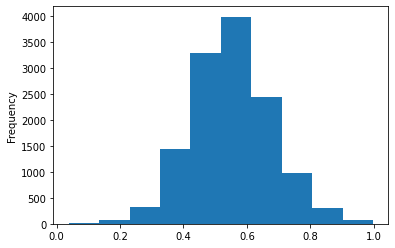

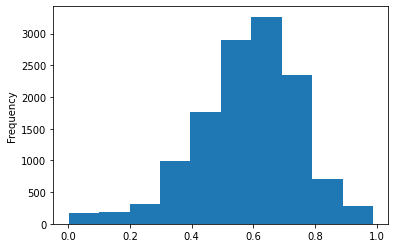

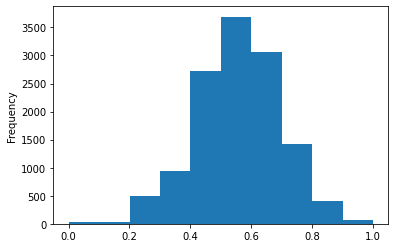

In [19]:
prediction['target_r'].plot(kind='hist')
plt.show()
prediction['target_g'].plot(kind='hist')
plt.show()
prediction['target_b'].plot(kind='hist')
plt.show()

In [21]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)


In [26]:
prediction = pd.DataFrame(et_mpred, columns=target.columns)

In [27]:
prediction.shape, test.shape

((12910, 3), (12910, 14))

In [28]:
prediction.target_r.nunique()

8106

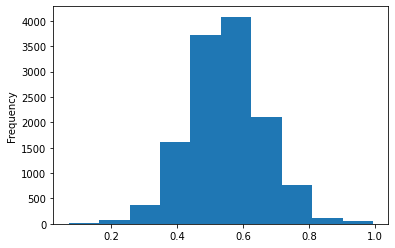

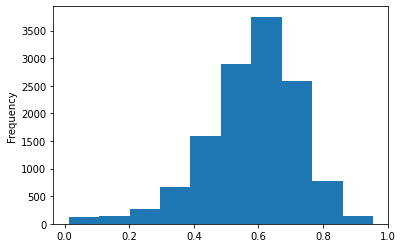

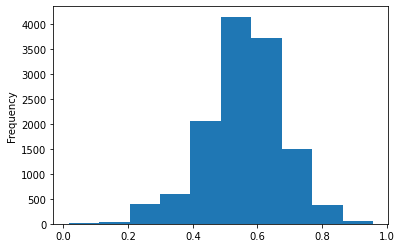

In [29]:
prediction['target_r'].plot(kind='hist')
plt.show()
prediction['target_g'].plot(kind='hist')
plt.show()
prediction['target_b'].plot(kind='hist')
plt.show()

In [30]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)


In [31]:
prediction['target_r'].value_counts()

0.491559    35
0.550515    34
0.662166    29
0.552958    27
0.485471    25
            ..
0.625118     1
0.474563     1
0.655784     1
0.634691     1
0.487490     1
Name: target_r, Length: 8106, dtype: int64

# TImeSeries MLP

In [32]:
train = pd.concat([train, target], axis=1)

In [33]:
# train = train.drop(['Moons', 'id'], axis=1)

In [34]:
train.shape[0] - (4687)

10000

In [35]:
validation_data = train[10000: ]
train_data = train[:10000]
train_data.shape

(10000, 17)

In [36]:
features = [f for f in train_data.columns if 'Feature' in f]
len(features)

14

# TRAINING

In [37]:
def scorer(y_test, y_pred):
    score = (stats.spearmanr(y_test, y_pred))[0]
    # print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))
    return score

In [38]:
# train[:10][['Feature_1', 'target_r']]

In [39]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()   
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences):
            break
# gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-3], sequences[end_ix-1, -3:]
        # print(seq_x.shape)
        # print(seq_y.shape)
        # print(seq_x, seq_y)
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)



In [40]:
train_data_arr = np.array(train_data)
validation_data_arr = np.array(validation_data)

In [41]:
train_data_arr.shape, validation_data_arr.shape

((10000, 17), (4687, 17))

In [42]:
%matplotlib inline
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

TIME STEPS : -------->  25
Epoch 00006: early stopping


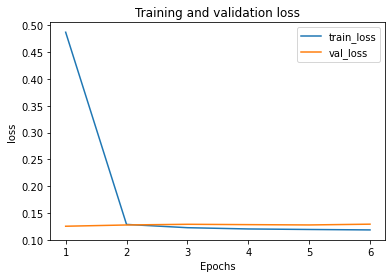

[25, -0.0575363279231588, -0.0365473625204379, 0.04234836696057295]
 
 
TIME STEPS : -------->  26
Epoch 00016: early stopping


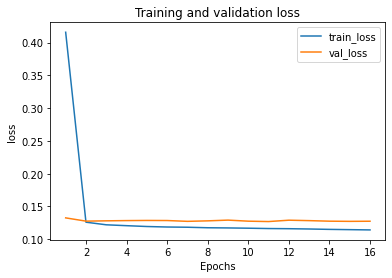

[26, 0.060317504632863804, 0.10127488116155317, 0.09765704278278443]
 
 
TIME STEPS : -------->  27
Epoch 00006: early stopping


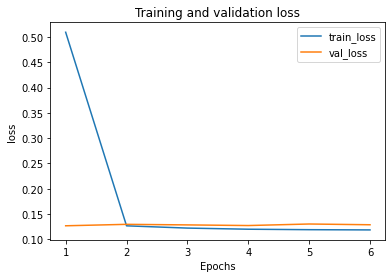

[27, -0.11710145900117791, -0.02979990197905079, 0.01378053797326852]
 
 
TIME STEPS : -------->  28
Epoch 00015: early stopping


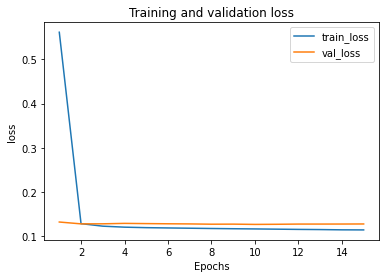

[28, 0.09932784339419552, 0.10154215411552765, 0.10492845915225468]
 
 
TIME STEPS : -------->  29
Epoch 00007: early stopping


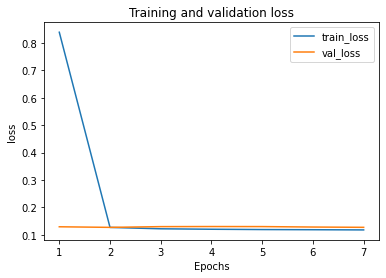

[29, -0.06495631328179989, -0.00707873535595253, 0.058188099637846956]
 
 
TIME STEPS : -------->  30
Epoch 00007: early stopping


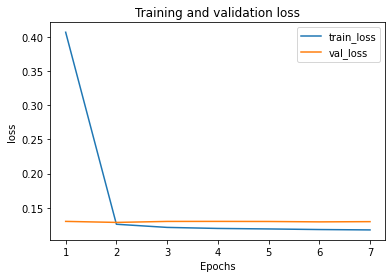

[30, -0.0660549306255161, -0.006270162843322868, 0.058339049858532534]
 
 
TIME STEPS : -------->  31
Epoch 00014: early stopping


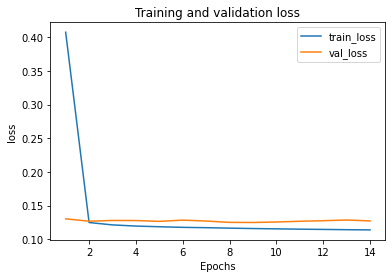

[31, 0.1048355822132185, 0.10241884632251338, 0.1060093944738821]
 
 
TIME STEPS : -------->  32
Epoch 00015: early stopping


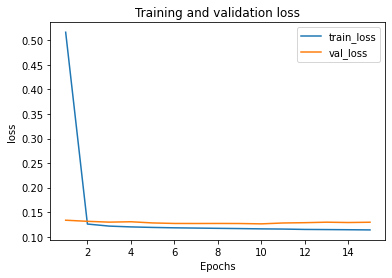

[32, 0.09610861205997966, 0.11976677122699705, 0.11651264667374339]
 
 
TIME STEPS : -------->  33
Epoch 00010: early stopping


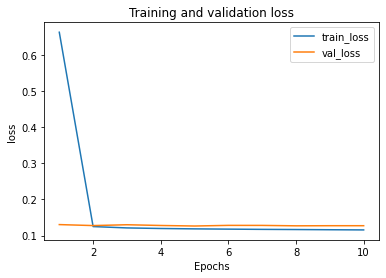

[33, 0.05254995032984739, 0.09505314808484701, 0.10238369302218547]
 
 
TIME STEPS : -------->  34
Epoch 00013: early stopping


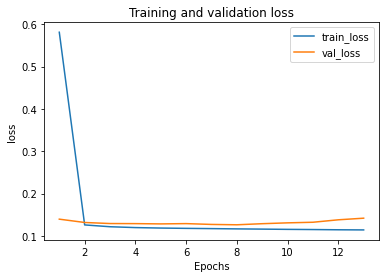

[34, 0.0400508907883092, 0.09428221184840807, 0.10542398674514486]
 
 
TIME STEPS : -------->  35
Epoch 00015: early stopping


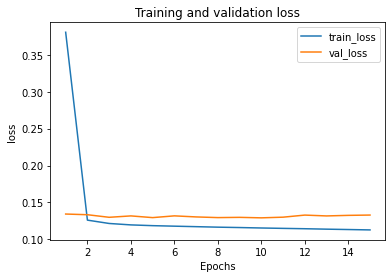

[35, 0.0873539794482366, 0.0965237089027378, 0.09842747925245764]
 
 


In [43]:
np.random.seed(60)
df = []
for i in range(25, 36):
    n_steps = i
    print( "TIME STEPS : --------> " , i)
    X_train, y_train = split_sequences(train_data_arr, n_steps)
    X_val, y_val = split_sequences(validation_data_arr, n_steps)

    n_input = X_train.shape[1] * X_train.shape[2]
    X_train = X_train.reshape((X_train.shape[0], n_input))
    X_val = X_val.reshape((X_val.shape[0], n_input))

    from keras.models import Sequential
    from keras.layers import Dense

    model = Sequential()
    model.add(Dense(1024, activation='sigmoid', input_dim=n_input))
    model.add(Dense(512, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(150, activation='relu'))
    # model.add(Dense(50, activation='relu'))
    model.add(Dense(3))
    model.compile(optimizer='rmsprop', loss='mse')


    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    batch_size = 64
    epochs = 250

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=None, validation_data=(X_val, y_val), 
                        callbacks=[early_stopping, mcp_save], shuffle=False)

    
    plot_metric(history, 'loss')
    plt.show()

    model.load_weights('model.hdf5')
    preds= model.predict(X_val, batch_size=batch_size)
    cols = ['target_r', 'target_g', 'target_b']
    preds = pd.DataFrame(preds, columns=cols)

    scores = []
    scores.append(n_steps)
    scores.append(scorer(y_val[:, 0], preds.target_r))
    scores.append(scorer(y_val[:, 1], preds.target_g))
    scores.append(scorer(y_val[:, 2], preds.target_b))
    df.append(pd.DataFrame(scores))
    print(scores)
    print(" ")
    print(" ")


In [44]:
# df

In [45]:
df = pd.concat(df, axis=1)
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)

In [46]:
df.T

,1,2,3
0,,,
25.0,-0.057536,-0.036547,0.042348
26.0,0.060318,0.101275,0.097657
27.0,-0.117101,-0.029800,0.013781
28.0,0.099328,0.101542,0.104928
29.0,-0.064956,-0.007079,0.058188
30.0,-0.066055,-0.006270,0.058339
31.0,0.104836,0.102419,0.106009
32.0,0.096109,0.119767,0.116513
33.0,0.052550,0.095053,0.102384


In [47]:
df.T.mean(axis=1)

0
25.0   -0.017245
26.0    0.086416
27.0   -0.044374
28.0    0.101933
29.0   -0.004616
30.0   -0.004662
31.0    0.104421
32.0    0.110796
33.0    0.083329
34.0    0.079919
35.0    0.094102
dtype: float64

# NEW

In [48]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [49]:
train = pd.concat([train, target], axis=1)
# train = train.drop(['id', 'Moons'], axis=1)

In [50]:
train.shape

(14687, 17)

In [51]:
features = [f for f in train_data.columns if 'Feature' in f]
len(features)

14

In [52]:
validation_data = train[10000: ]
train_data = train[:10000]

In [53]:
validation_data.shape[0] - 33

4654

In [54]:
test_merge = validation_data[4655:]
test_merge.shape

(32, 17)

In [55]:
test.shape

(12910, 14)

In [56]:
cols = ['target_r', 'target_g', 'target_b']
test_merge.drop(columns=cols, inplace=True)

In [57]:
validation_data = validation_data[:4655]
validation_data.shape

(4655, 17)

In [58]:
train_data_arr = np.array(train_data)
validation_data_arr = np.array(validation_data)
validation_data_arr.shape

(4655, 17)

(9968, 33, 14)
(4623, 33, 14)
Epoch 00008: early stopping


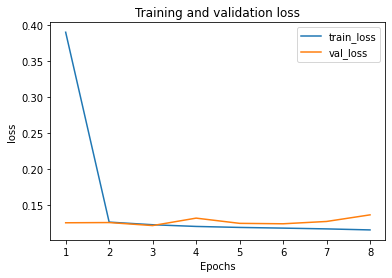

0.0605869376431924
0.12496924799329412
0.1322327818721643


In [59]:
np.random.seed(60)
n_steps = 33
X_train, y_train = split_sequences(train_data_arr, n_steps)
print(X_train.shape)
X_val, y_val = split_sequences(validation_data_arr, n_steps)
print(X_val.shape)
n_input = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_input))
X_val = X_val.reshape((X_val.shape[0], n_input))

from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(1024, activation='sigmoid', input_dim=n_input))
model.add(Dense(512, activation='relu'))
# model.add(Dense(256, activation='relu'))
model.add(Dense(150, activation='relu'))
# model.add(Dense(50, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='rmsprop', loss='mse')


early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

batch_size = 64
epochs = 250



history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=0, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, mcp_save], shuffle=True)


plot_metric(history, 'loss')

model.load_weights('model.hdf5')
preds= model.predict(X_val, batch_size=batch_size)
cols = ['target_r', 'target_g', 'target_b']
preds = pd.DataFrame(preds, columns=cols)

print(scorer(y_val[:, 0], preds.target_r))
print(scorer(y_val[:, 1], preds.target_g))
print(scorer(y_val[:, 2], preds.target_b))

In [60]:
X_val.shape

(4623, 462)

In [61]:
test_data_with_lag = pd.concat([test_merge, test])
test_data_with_lag.shape

(12942, 14)

In [62]:
test.shape[0]

12910

In [63]:
def split_sequences_for_prediction(sequences, n_steps):
    X= list()   
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences):
            break
# gather input and output parts of the pattern
        seq_x =sequences[i:end_ix]
        # print(seq_x)
        X.append(seq_x)
    return np.array(X)

In [64]:
preds_data = split_sequences_for_prediction(np.array(test_data_with_lag[features]), 33)

In [65]:
preds_data.shape

(12910, 33, 14)

In [66]:
n_input

462

In [67]:
preds_data = preds_data.reshape((preds_data.shape[0], n_input))
preds_data.shape

(12910, 462)

In [73]:
prediction = pd.DataFrame(model.predict(preds_data, batch_size=batch_size))
prediction.columns = cols

In [78]:
prediction = (rf_mpred + et_mpred + model.predict(preds_data, batch_size=batch_size))/3

In [79]:
prediction = pd.DataFrame(prediction)
prediction.columns = cols

In [80]:
prediction['target_g'].nunique()

12910

In [81]:
test.shape, prediction.shape

((12910, 14), (12910, 3))

# Predictions

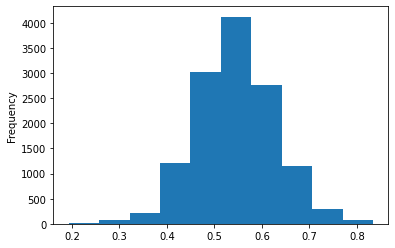

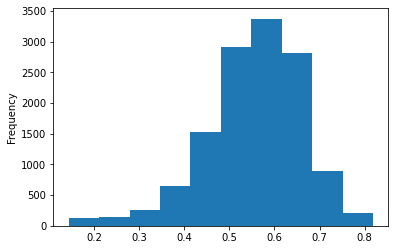

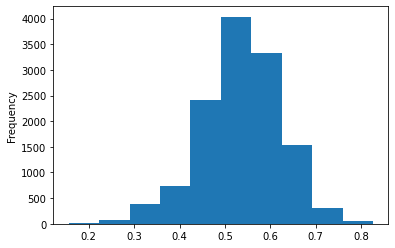

In [82]:
prediction['target_r'].plot(kind='hist')
plt.show()
prediction['target_g'].plot(kind='hist')
plt.show()
prediction['target_b'].plot(kind='hist')
plt.show()

In [83]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)
